# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env restrict the behaviour of RL learner to pair trading only

## Import the Custom Trading Env

In [1]:
import os
import csv
import pickle
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
from tqdm import trange
from stable_baselines3 import PPO, A2C, DDPG

from params import *
from utils.read2df import read2df, unify_dfs
from utils.clearlogs import clear_logs
from utils.rlmetrics import get_return, get_metrics
from envs.env_rl_restrict_thres import RL_RestrictFreeAmt_TradeEnv

folder_path = f"result/rl-restrict-thres-freeamt"
os.makedirs(folder_path, exist_ok=True)

## Prepare Trading Data
Load data from `preliminaries.ipynb`

In [2]:
with open('result/cointncorr.pickle', 'rb') as pk:
    cointncorr = pickle.load(pk)

with open('result/gridsearch/best_res.pickle', 'rb') as pk:
    best_profit, best_params = pickle.load(pk)

dfs = read2df(symbols=cointncorr[0], freqs={cointncorr[1]: freqs[cointncorr[1]]}, marketType='spot')
tics, df = unify_dfs(dfs, symbols=cointncorr[0], period=best_params['period'])

In [3]:
df.tail(10)

,time,close0,itvl,datetime,close1,spread,zscore
521369,1703818259999,0.000026,1m,2023-12-29 02:50:59.999,0.000028,-0.000002,0.083267
521370,1703818319999,0.000026,1m,2023-12-29 02:51:59.999,0.000028,-0.000002,0.082584
521371,1703818379999,0.000026,1m,2023-12-29 02:52:59.999,0.000028,-0.000002,0.063342
521372,1703818439999,0.000026,1m,2023-12-29 02:53:59.999,0.000028,-0.000002,0.088554
521373,1703818499999,0.000026,1m,2023-12-29 02:54:59.999,0.000028,-0.000002,0.086473
521374,1703818559999,0.000026,1m,2023-12-29 02:55:59.999,0.000028,-0.000002,0.224487
521375,1703818619999,0.000026,1m,2023-12-29 02:56:59.999,0.000028,-0.000002,0.257121
521376,1703818679999,0.000026,1m,2023-12-29 02:57:59.999,0.000028,-0.000002,0.291488
521377,1703818739999,0.000026,1m,2023-12-29 02:58:59.999,0.000028,-0.000002,0.536032
521378,1703818799999,0.000026,1m,2023-12-29 02:59:59.999,0.000028,-0.000002,1.049747


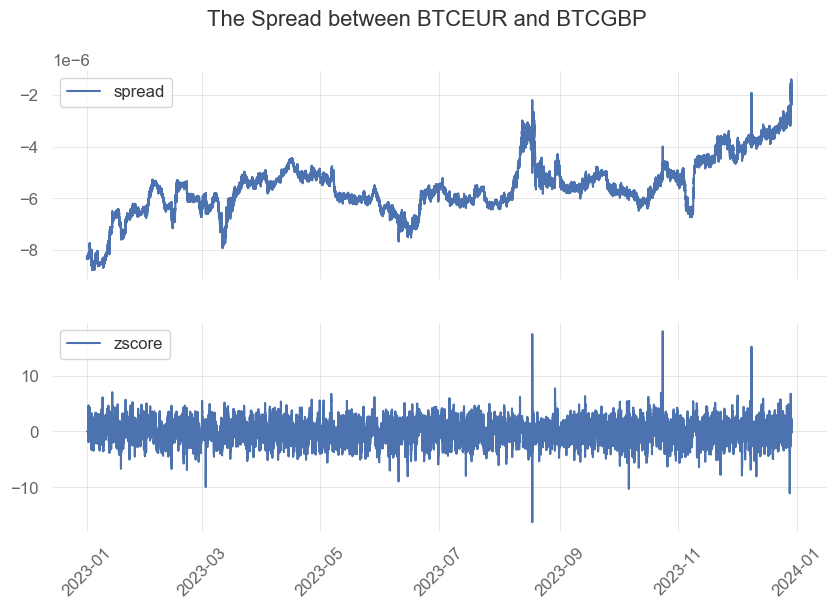

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(df['datetime'], df['spread'], label='spread')
ax2.plot(df['datetime'], df['zscore'], label='zscore')

ax1.legend()
ax2.legend()
plt.suptitle(f'The Spread between {cointncorr[0][0]} and {cointncorr[0][1]}')

plt.xticks(rotation=45)
plt.show()

In [5]:
train = df[(df['datetime'] >= datetime.strptime(start_date, date_format)) & (df['datetime'] < datetime.strptime(trade_date, date_format))]
test = df[(df['datetime'] >= datetime.strptime(trade_date, date_format)) & (df['datetime'] < datetime.strptime(end_date, date_format))]

max_train_len = int((len(train)-best_params['period'])*0.95)
print(f"The length of our training data: {len(train)}")

The length of our training data: 87840


## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [6]:
from stable_baselines3.common.env_checker import check_env

env = RL_RestrictFreeAmt_TradeEnv(train)
check_env(env)

c:\Users\hyan212\Miniconda3\envs\btrl\lib\site-packages\stable_baselines3\common\env_checker.py:452: UserWarning: Your action space has dtype float64, we recommend using np.float32 to avoid cast errors.
  warnings.warn(


In [7]:
test_env_expt = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_expt.csv", verbose=1)

try:
    os.remove(f"{folder_path}/networth_expt.csv")
except OSError:
    pass

obs, _ = test_env_expt.reset()

for i in trange(20):
    obs, rewards, terminated, truncated, info = test_env_expt.step(action=env.action_space.sample())
    # test_env_expt.render()

test_env_expt.close()

100%|██████████| 20/20 [00:00<00:00, 141.63it/s]

Finished
networth: 0.986442735659478


Tensorboard

## Train the Model with Trading Env

In [8]:
log_path = f"logs/restrict_thres_freeamt/"
clear_logs(log_path)

# Read more about tensorboard
# https://github.com/tensorflow/tensorboard/blob/master/README.md
# https://www.tensorflow.org/tensorboard/get_started

Deleted: logs/restrict_thres_freeamt/A2C_1
Deleted: logs/restrict_thres_freeamt/PPO_1


In [9]:
'''PPO'''

model_ppo = PPO("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_ppo.learn(total_timesteps=max_train_len, progress_bar=False)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

In [10]:
'''A2C'''

model_a2c = A2C("MultiInputPolicy", env, verbose=0, gamma=1, tensorboard_log=log_path)
model_a2c.learn(total_timesteps=max_train_len, progress_bar=True)
model_a2c.save(f"{folder_path}/a2c_pairtrading")

Output()

In [11]:
# '''
# DDPG
# '''

# model_ddpg = DDPG("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
# model_ddpg.learn(total_timesteps=max_train_len*0.95, progress_bar=True)
# model_ddpg.save(f"{folder_path}/dqn_pairtrading")

## Create the Custom Test Env

In [12]:
test_env_ppo = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_ppo.csv", verbose=1)
test_env_a2c = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_a2c.csv", verbose=1)
test_env_ddpg = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_ddpg.csv", verbose=1)
test_env_expt = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_expt.csv", verbose=1)

In [13]:
max_test_len = int(len(test) * 0.95)
print(f"The length of our test data: {max_test_len}")

The length of our test data: 38475


## Test Env with Trained Model

In [14]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
except OSError:
    pass

obs, _ = test_env_ppo.reset()

for i in trange(max_test_len):
    action, _states = model_ppo.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_ppo.step(action)
    if i%int(max_test_len/10)==0:
        test_env_ppo.render()

test_env_ppo.close()

  0%|          | 11/38475 [00:00<05:51, 109.54it/s]

signal: {'holdings': array([ 0., -0.], dtype=float32), 'zone': 1, 'zscore': array([0.9079923], dtype=float32)}, action: -1.0, reward:0.0, networth: 1.0


 10%|█         | 3863/38475 [00:46<04:44, 121.49it/s]

signal: {'holdings': array([-0.6079341,  0.6079341], dtype=float32), 'zone': 1, 'zscore': array([0.4867236], dtype=float32)}, action: -1.0, reward:1.0, networth: 0.312


 20%|██        | 7709/38475 [01:18<04:29, 113.97it/s]

signal: {'holdings': array([-0.9701697,  0.9701697], dtype=float32), 'zone': 1, 'zscore': array([1.3618864], dtype=float32)}, action: -1.0, reward:1.0, networth: 0.1101


 30%|███       | 11566/38475 [01:50<03:46, 118.84it/s]

signal: {'holdings': array([ 0.3294709, -0.3294709], dtype=float32), 'zone': 2, 'zscore': array([-0.17013337], dtype=float32)}, action: 1.0, reward:0.0, networth: 0.033


 40%|████      | 15400/38475 [02:22<03:08, 122.66it/s]

signal: {'holdings': array([-0.9980444,  0.9980444], dtype=float32), 'zone': 1, 'zscore': array([0.60360646], dtype=float32)}, action: -1.0, reward:1.0, networth: 0.0089


 50%|█████     | 19262/38475 [02:54<02:37, 121.98it/s]

signal: {'holdings': array([-0.9654026,  0.9654026], dtype=float32), 'zone': 1, 'zscore': array([0.9135977], dtype=float32)}, action: -1.0, reward:1.0, networth: 0.0038


 60%|██████    | 23095/38475 [03:26<02:08, 120.12it/s]

signal: {'holdings': array([-0.9972234,  0.9972234], dtype=float32), 'zone': 1, 'zscore': array([0.58071077], dtype=float32)}, action: -1.0, reward:1.0, networth: 0.0014


 70%|███████   | 26953/38475 [03:58<01:35, 120.04it/s]

signal: {'holdings': array([ 0.99248284, -0.99248284], dtype=float32), 'zone': 2, 'zscore': array([0.11167536], dtype=float32)}, action: 0.683759868144989, reward:0.0, networth: 0.0005


 80%|████████  | 30795/38475 [04:31<01:02, 122.85it/s]

signal: {'holdings': array([-0.9558802,  0.9558802], dtype=float32), 'zone': 1, 'zscore': array([1.4829485], dtype=float32)}, action: -1.0, reward:1.0, networth: 0.0002


 90%|█████████ | 34643/38475 [05:03<00:31, 123.30it/s]

signal: {'holdings': array([ 0.9369715, -0.9369715], dtype=float32), 'zone': 2, 'zscore': array([-0.27726954], dtype=float32)}, action: 1.0, reward:0.0, networth: 0.0001


100%|██████████| 38475/38475 [05:34<00:00, 114.98it/s]

signal: {'holdings': array([ 0.97736096, -0.97736096], dtype=float32), 'zone': 3, 'zscore': array([-1.438743], dtype=float32)}, action: 1.0, reward:1.0, networth: 0.0
Finished
networth: 2.3468264596305403e-05


In [15]:
try:
    os.remove(f"{folder_path}/networth_a2c.csv")
except OSError:
    pass

obs, _ = test_env_a2c.reset()

for i in trange(max_test_len):
    action, _states = model_a2c.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_a2c.step(action)
    if i%int(max_test_len/10)==0:
        test_env_a2c.render()

test_env_a2c.close()

  0%|          | 12/38475 [00:00<05:22, 119.41it/s]

signal: {'holdings': array([ 0., -0.], dtype=float32), 'zone': 1, 'zscore': array([0.9079923], dtype=float32)}, action: -1.0, reward:0.0, networth: 1.0


 10%|█         | 3863/38475 [00:44<05:20, 107.91it/s]

signal: {'holdings': array([ 0.99722916, -0.99722916], dtype=float32), 'zone': 1, 'zscore': array([0.4867236], dtype=float32)}, action: 1.0, reward:0.0, networth: 1.0018


 20%|██        | 7712/38475 [01:17<04:18, 119.19it/s]

signal: {'holdings': array([-0.998005,  0.998005], dtype=float32), 'zone': 1, 'zscore': array([1.3618864], dtype=float32)}, action: -1.0, reward:1.0, networth: 1.0005


 30%|███       | 11557/38475 [01:50<03:42, 120.73it/s]

signal: {'holdings': array([ 0.9974689, -0.9974689], dtype=float32), 'zone': 2, 'zscore': array([-0.17013337], dtype=float32)}, action: 1.0, reward:0.0, networth: 1.0816


 40%|████      | 15411/38475 [02:22<03:16, 117.39it/s]

signal: {'holdings': array([-1.0001036,  1.0001036], dtype=float32), 'zone': 1, 'zscore': array([0.60360646], dtype=float32)}, action: -1.0, reward:1.0, networth: 1.1141


 50%|█████     | 19248/38475 [02:54<02:40, 119.64it/s]

signal: {'holdings': array([-0.9980511,  0.9980511], dtype=float32), 'zone': 1, 'zscore': array([0.9135977], dtype=float32)}, action: -1.0, reward:1.0, networth: 1.138


 60%|██████    | 23106/38475 [03:27<02:07, 120.58it/s]

signal: {'holdings': array([-0.99987406,  0.99987406], dtype=float32), 'zone': 1, 'zscore': array([0.58071077], dtype=float32)}, action: -1.0, reward:1.0, networth: 1.1636


 70%|███████   | 26944/38475 [03:59<01:37, 117.69it/s]

signal: {'holdings': array([ 0.9979962, -0.9979962], dtype=float32), 'zone': 2, 'zscore': array([0.11167536], dtype=float32)}, action: 1.0, reward:0.0, networth: 1.1906


 80%|████████  | 30798/38475 [04:35<01:08, 111.91it/s]

signal: {'holdings': array([-0.9992607,  0.9992607], dtype=float32), 'zone': 1, 'zscore': array([1.4829485], dtype=float32)}, action: -1.0, reward:1.0, networth: 1.3028


 90%|█████████ | 34642/38475 [05:10<00:32, 116.25it/s]

signal: {'holdings': array([ 0.9949571, -0.9949571], dtype=float32), 'zone': 2, 'zscore': array([-0.27726954], dtype=float32)}, action: 1.0, reward:0.0, networth: 1.4183


100%|██████████| 38475/38475 [05:43<00:00, 112.14it/s]

signal: {'holdings': array([ 0.99879915, -0.99879915], dtype=float32), 'zone': 3, 'zscore': array([-1.438743], dtype=float32)}, action: 1.0, reward:1.0, networth: 1.5073
Finished
networth: 1.507310377813599


In [16]:
# try:
#     os.remove(f"{folder_path}/networth_ddpg.csv")
# except OSError:
#     pass

# obs, _ = test_env_ddpg.reset()

# for i in trange(max_test_len):
#     action, _states = model_ddpg.predict(obs)
#     obs, rewards, terminated, truncated, info = test_env_ddpg.step(action)
#     if i%int(max_test_len/10)==0:
#         test_env_ddpg.render()

# test_env_ddpg.close()

## Also run randomly generated actions

In [17]:
try:
    os.remove(f"{folder_path}/networth_expt.csv")
except OSError:
    pass

obs, _ = test_env_expt.reset()

for i in trange(max_test_len):
    obs, rewards, terminated, truncated, info = test_env_expt.step(action=env.action_space.sample())
    if i%int(max_test_len/10)==0:
        test_env_expt.render()

test_env_expt.close()

  0%|          | 0/38475 [00:00<?, ?it/s]

signal: {'holdings': array([ 0., -0.], dtype=float32), 'zone': 1, 'zscore': array([0.9079923], dtype=float32)}, action: 0.12398778506703523, reward:0.0, networth: 1.0


 10%|█         | 3869/38475 [00:28<03:36, 159.81it/s]

signal: {'holdings': array([ 0.82819784, -0.82819784], dtype=float32), 'zone': 1, 'zscore': array([0.4867236], dtype=float32)}, action: -0.6764483049237193, reward:0.0, networth: 0.0799


 20%|██        | 7720/38475 [00:52<03:01, 169.21it/s]

signal: {'holdings': array([-0.6290722,  0.6290722], dtype=float32), 'zone': 1, 'zscore': array([1.3618864], dtype=float32)}, action: -0.4614525814188808, reward:1.0, networth: 0.0057


 30%|███       | 11568/38475 [01:15<02:41, 167.10it/s]

signal: {'holdings': array([-0.51491636,  0.51491636], dtype=float32), 'zone': 2, 'zscore': array([-0.17013337], dtype=float32)}, action: -0.34378642566718054, reward:0.0, networth: 0.0004


 40%|████      | 15416/38475 [01:39<02:22, 162.32it/s]

signal: {'holdings': array([-0.3815093,  0.3815093], dtype=float32), 'zone': 1, 'zscore': array([0.60360646], dtype=float32)}, action: 0.1567710965321858, reward:-0.0, networth: 0.0


 50%|█████     | 19264/38475 [02:02<01:58, 162.24it/s]

signal: {'holdings': array([ 0.31655088, -0.31655088], dtype=float32), 'zone': 1, 'zscore': array([0.9135977], dtype=float32)}, action: 0.9518097652528748, reward:0.0, networth: 0.0


 60%|██████    | 23113/38475 [02:26<01:34, 162.80it/s]

signal: {'holdings': array([ 0.37403414, -0.37403414], dtype=float32), 'zone': 1, 'zscore': array([0.58071077], dtype=float32)}, action: -0.6684029417590076, reward:-0.0, networth: 0.0


 70%|███████   | 26959/38475 [02:49<01:10, 163.89it/s]

signal: {'holdings': array([ 0.824075, -0.824075], dtype=float32), 'zone': 2, 'zscore': array([0.11167536], dtype=float32)}, action: -0.023222543016939046, reward:0.0, networth: 0.0


 80%|████████  | 30800/38475 [03:14<00:46, 164.81it/s]

signal: {'holdings': array([ 0.26377094, -0.26377094], dtype=float32), 'zone': 1, 'zscore': array([1.4829485], dtype=float32)}, action: -0.41673410915374176, reward:-0.0, networth: 0.0


 90%|█████████ | 34645/38475 [03:37<00:23, 163.31it/s]

signal: {'holdings': array([ 0.9168231, -0.9168231], dtype=float32), 'zone': 2, 'zscore': array([-0.27726954], dtype=float32)}, action: -0.9340660711261748, reward:-0.0, networth: 0.0


100%|██████████| 38475/38475 [04:01<00:00, 159.55it/s]

signal: {'holdings': array([-0.9845326,  0.9845326], dtype=float32), 'zone': 3, 'zscore': array([-1.438743], dtype=float32)}, action: -0.095375015865931, reward:0.0, networth: 0.0
Finished
networth: 6.900273920016868e-12


### Analyze with Quanstats

In [18]:
os.remove(f"{folder_path}/networth_expt.csv") if os.path.exists(f"{folder_path}/networth_expt.csv") else None

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

The ending capital of networth_a2c.csv is ['2023-12-28 08:15:59.999000', '1.507310377813599']
The ending capital of networth_ppo.csv is ['2023-12-28 08:15:59.999000', '2.3468264596305403e-05']
The best model is networth_a2c.csv


In [19]:
best_return = get_return(f'{folder_path}/{best_model}')
get_metrics(best_return)

Compound annual growth rate: 31772%
Total orders count: 38474
Total long action: 0
Total short action: 0
Won orders count: 301
Lost orders count: 66
Win/Loss order ratio: 4.5606060606060606
Max win: 0.016119216680602788
Max Loss: -0.012341288501904302
Avg order pnl: 1.3185797624723164e-05
Avg order pnl won: 0.0022274703361753944
Avg order pnl lost: -0.002472093839018101


In [20]:
best_return

,values,action,zscore,position,price0,price1,pnl,returns
datetime,,,,,,,,
2023-12-01 15:02:59.999,1.00000,-1.0,0.796502,[-1.0007731 1.0007731],0.000028,0.000032,0.0,0.0
2023-12-01 15:03:59.999,1.00000,-1.0,0.927468,[-0.99968714 0.99968714],0.000028,0.000032,0.0,0.0
2023-12-01 15:04:59.999,1.00000,-1.0,0.979107,[-0.99952704 0.99952704],0.000028,0.000032,0.0,0.0
2023-12-01 15:05:59.999,1.00000,-1.0,0.925928,[-0.999141 0.999141],0.000028,0.000032,0.0,0.0
2023-12-01 15:06:59.999,1.00000,-1.0,0.975951,[-1.0008103 1.0008103],0.000028,0.000032,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-12-28 08:11:59.999,1.50731,1.0,-1.625097,[ 0.996713 -0.996713],0.000026,0.000029,0.0,0.0
2023-12-28 08:12:59.999,1.50731,1.0,-1.587612,[ 0.9981585 -0.9981585],0.000026,0.000029,0.0,0.0
2023-12-28 08:13:59.999,1.50731,1.0,-1.892647,[ 0.9975779 -0.9975779],0.000026,0.000029,0.0,0.0


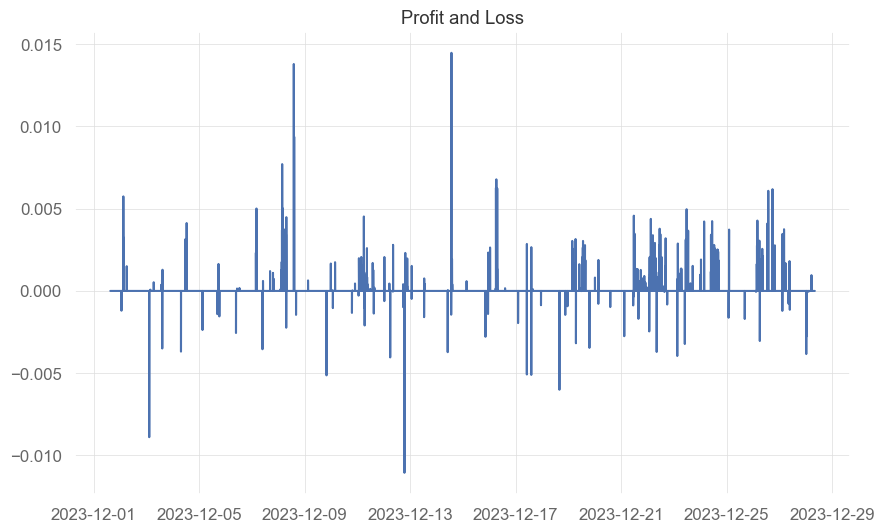

In [21]:
fig, ax = plt.subplots()

ax.set_title("Profit and Loss")
ax.plot(best_return['returns'])

plt.show()

                           Strategy
-------------------------  ----------
Start Period               2023-12-01
End Period                 2023-12-28
Risk-Free Rate             0.0%
Time in Market             1.0%

Cumulative Return          50.73%
CAGR﹪                     5235.75%

Sharpe                     0.67
Prob. Sharpe Ratio         100.0%
Smart Sharpe               0.64
Sortino                    1.4
Smart Sortino              1.35
Sortino/√2                 0.99
Smart Sortino/√2           0.95
Omega                      3.94

Max Drawdown               -1.57%
Longest DD Days            6
Volatility (ann.)          0.4%
Calmar                     3333.65
Skew                       13.23
Kurtosis                   856.49

Expected Daily %           0.0%
Expected Monthly %         50.73%
Expected Yearly %          50.73%
Kelly Criterion            61.19%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.04%
Expected Shortfall (cVaR)  -0.04%

Max Consecutive Wins    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-12-17,2023-12-18,2023-12-19,3,-1.570573,-1.526228
2,2023-12-12,2023-12-12,2023-12-14,3,-1.314636,-1.086610
3,2023-12-03,2023-12-04,2023-12-08,6,-1.268410,-1.078937
4,2023-12-27,2023-12-28,2023-12-28,1,-0.776297,-0.771734
5,2023-12-19,2023-12-21,2023-12-21,2,-0.603704,-0.482711


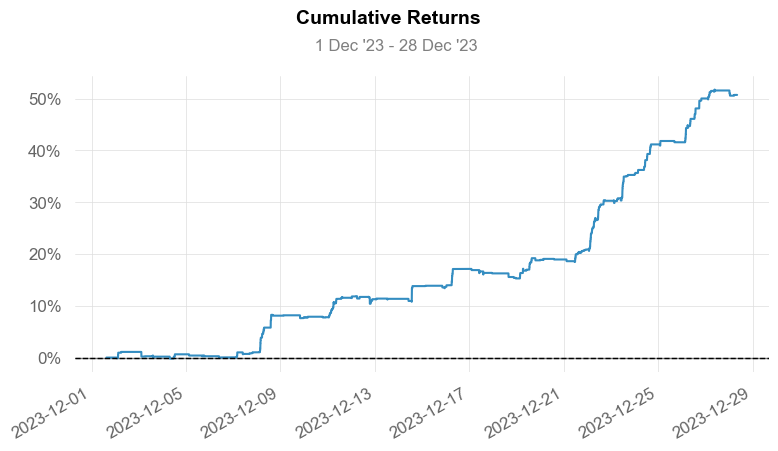

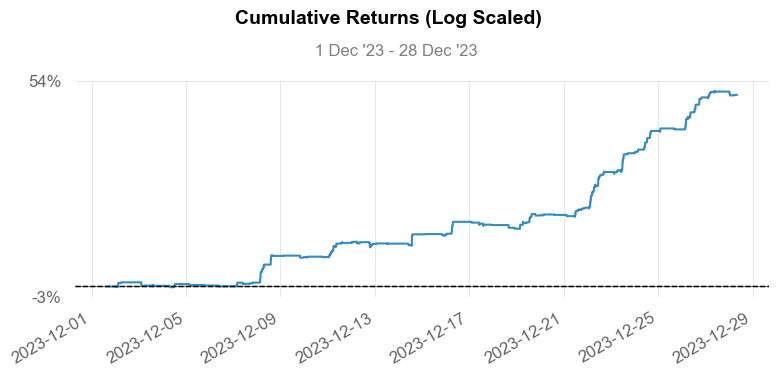

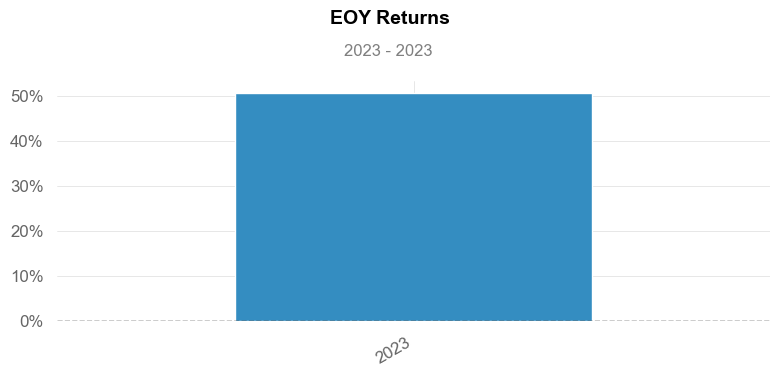

c:\Users\hyan212\Miniconda3\envs\btrl\lib\site-packages\quantstats\_plotting\core.py:516: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  _sns.kdeplot(data=combined_returns, color="black", ax=ax)


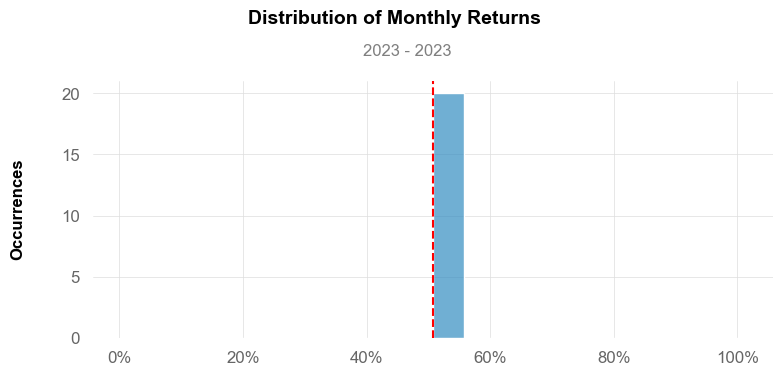

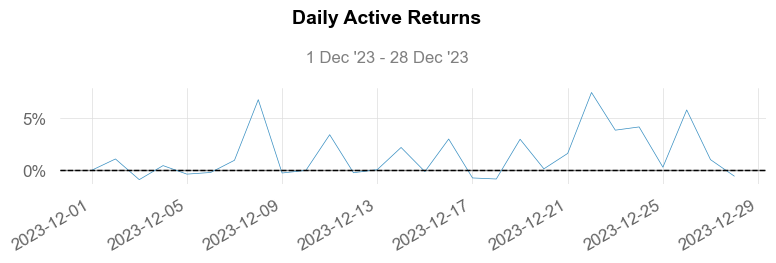

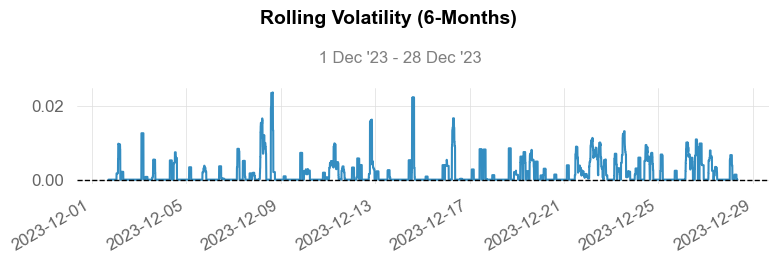

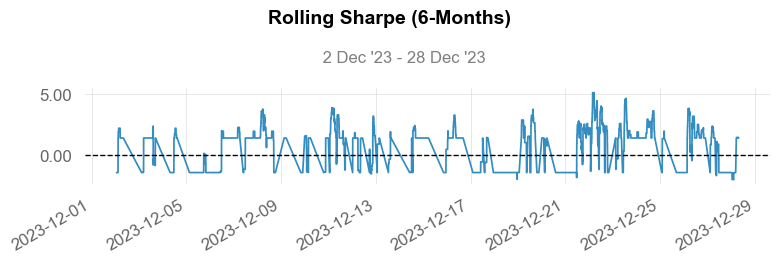

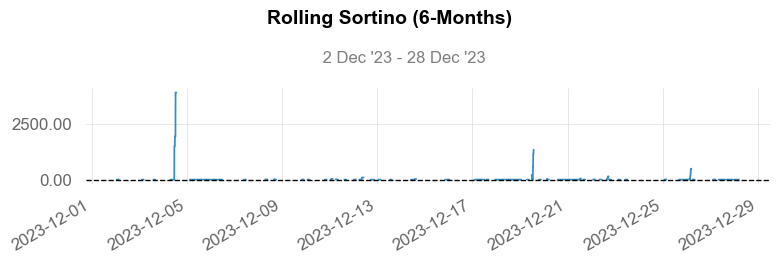

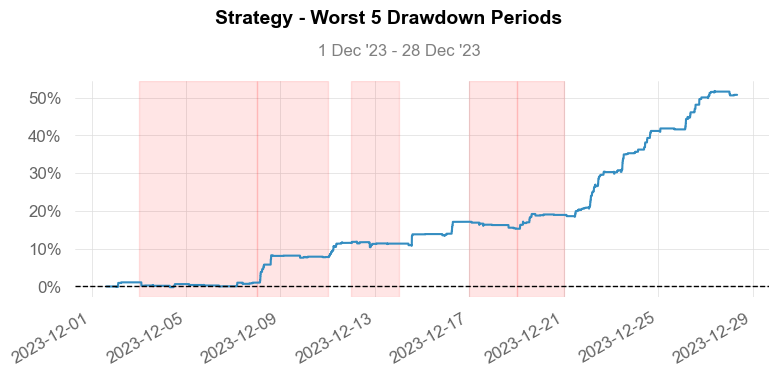

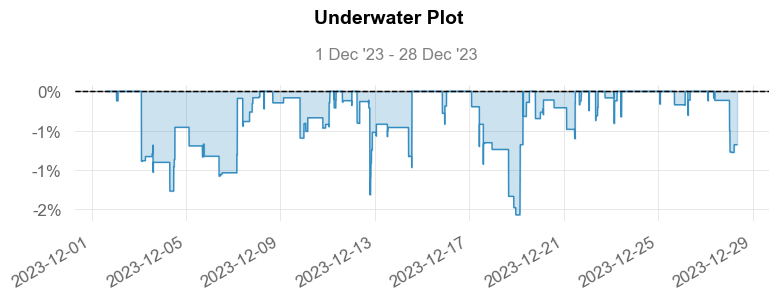

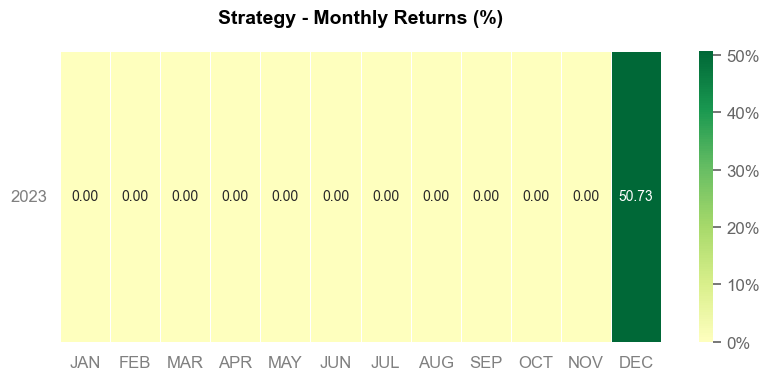

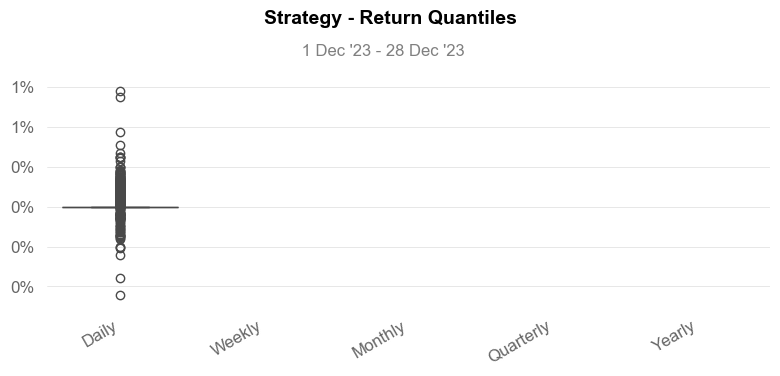

In [22]:
qs.reports.full(best_return['returns'])